# Interactions between ProTα and Histone H1.0

In [1]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Strategy

Ionic strength range in Borgia et al. 2018
- *In vitro* FRET [mM]: 165, 180, 205, 240, 290, 330, 340
- *In silico* coarse grain [mM]: 165

They do not report a box size, but report interactions starting from 22 nm COM distance as well as 7 fM KD from CG MD.

$K_{D} = $

## Data preparation

### Templates

In [7]:
# Defining UniProt IDs / Trivial IDs
entries = {
    'H1-0': 'P07305',
    'ProTa': 'P06454',
}
templates = pd.DataFrame({'uniprot_id': entries.values(),
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None},
                          index=entries.keys())

In [8]:
# Collecting metadata
for id, row in templates.iterrows():
    name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    templates.loc[id] = {
        'uniprot_id': row.uniprot_id,
        'name': name,
        'description': desc,
        'species': spec,
        'sequence': seq}

In [9]:
# Viewing final templates
templates

,uniprot_id,name,description,species,sequence
H1-0,P07305,H10_HUMAN,Histone H1.0,Homo sapiens (Human),MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
ProTa,P06454,PTMA_HUMAN,Prothymosin alpha,Homo sapiens (Human),MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...


In [10]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Data

In [9]:
# Getting template metadata
with open('prota_h1-0.json', 'r') as file:
    metadata = json.load(file)

In [12]:
# Getting IDR of H1.0 (C-terminal IDR)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['H1-0']['uniprot_id'], i_idr=-1, length_order=False)
H10 = {'template': 'H1-0', 'sequence': seq, 'location': loc, 'region': 'CTD', 'variant': 'Wild type'}

# Getting IDR of ProTa (Full-length IDP)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['ProTa']['uniprot_id'], i_idr=-1, length_order=True)
ProTa = {'template': 'ProTa', 'sequence': seq, 'location': loc, 'region': 'FL', 'variant': 'Wild type'}

In [13]:
# Assembling all data entries for simulation
data = pd.DataFrame([H10, ProTa], index = ['H1-0_WT', 'ProTa_WT'])
data

,template,sequence,location,region,variant
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type
ProTa_WT,ProTa,MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...,0:111,FL,Wild type


In [14]:
# Saving sequences
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [16]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Topologies

In [2]:
# Getting compact frame topologies
cond = 'default'
trajs = {}

# Looping over proteins
for prot in ['PROTA_WT', 'H1-0_WT']:

    # Loading trajectory
    traj_path = f'results/single_chain/{cond}/{prot}/traj.dcd'
    top_path  = f'results/single_chain/{cond}/{prot}/top.pdb'

    # Selecting most compact frame
    compact_frame = analyse_utils.compact_frame(traj_path, top_path)
    trajs[prot] = compact_frame
trajs

{'PROTA_WT': <mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7fdb7040d1e0>,
 'H1-0_WT': <mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7fdc845f9de0>}

In [ ]:
# Saving single topologies
for prot, traj in trajs.items():
    traj.save_pdb(f'data/{prot}.pdb')

In [3]:
# Translating topologies
trajs['PROTA_WT'].xyz = trajs['PROTA_WT'].xyz + [10, 0, 0]
trajs['H1-0_WT'].xyz = trajs['H1-0_WT'].xyz + [0, 0, 0]

In [9]:
# Merging topologies
merged_traj = simulate_utils.merge_topologies(list(trajs.values()), boxlength=100)

In [10]:
# Saving merged topologies
merged_traj.save('data/H1-0_PROTA_WT.pdb')

In [5]:
merged_traj.topology.to_dataframe()

(     serial name element  resSeq resName  chainID segmentID
 0         1    M       C       0       M        0          
 1         2    S       C       1       S        0          
 2         3    D       C       2       D        0          
 3         4    A       C       3       A        0          
 4         5    A       C       4       A        0          
 ..      ...  ...     ...     ...     ...      ...       ...
 217     107    A       C     106       A        1          
 218     108    G       C     107       G        1          
 219     109    K       C     108       K        1          
 220     110    K       C     109       K        1          
 221     111    K       C     110       K        1          
 
 [222 rows x 7 columns],
 array([[  0.,   1.,   0.,   0.],
        [  1.,   2.,   0.,   0.],
        [  2.,   3.,   0.,   0.],
        [  4.,   5.,   0.,   0.],
        [  5.,   6.,   0.,   0.],
        [  6.,   7.,   0.,   0.],
        [  7.,   8.,   0.,   0.],
   

In [20]:
# Identifying chains
simulate_utils.extract_sequences('data/H1-0_PROTA_WT.pdb').groupby('chain').sum(numeric_only=True)

,res,MW,AH_lambda,AH_sigma,q
chain,,,,,
0,6105,12202.65,23.615885,62.712,-44
1,18426,11778.21,33.335545,64.274,42


PROTA_WT
H1-0_WT


## Analysis

### Wild type ProTa - H1.0[CTD]

In [62]:
# Loading trajectory
traj = md.load_dcd("results/two_chain/traj.dcd", "results/two_chain/top.pdb")
residues = simulate_utils.extract_sequences("results/two_chain/top.pdb")

In [69]:
# Mapping chains to proteins
chain_map = {
    0: 'ProTa',
    1: 'H1-0 CTD'
}
residues['chain_id'] = residues['chain'].map(chain_map)
residues.groupby('chain_id').q.sum()

chain_id
H1-0 CTD    42
ProTa      -44
Name: q, dtype: int64

#### Contact maps

In [47]:
# Calculating distances
distances = analyse_utils.compute_distance_contact(traj)

In [87]:
# Defining distance masks
intra_mask = []
for i in residues.res:
    for j in residues.res:
        intra_mask.append(residues.chain[i] == residues.chain[j])
intra_mask = np.reshape(intra_mask, [len(residues)]*2)
inter_mask = ~intra_mask

/tmp/ipykernel_9650/4204315499.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Blues_r'))


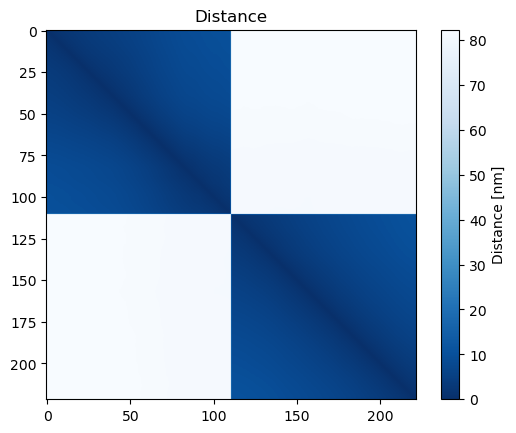

In [111]:
# Plotting distance contact map
plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Blues_r'))
plt.title("Distance")
plt.colorbar(label="Distance [nm]")